# Fantasy Premier League team prediction
### Intro

Attempt to use some sort of AI to generate the optimal team, along with transfer and chip strategy eventually. Data from https://github.com/vaastav/Fantasy-Premier-League/.

Player points prediction is probably the most technical element of a task like this. It would involve not only gathering the most common data but also searching for alternative data that could improve accuracy, such as betting odds for various markets or even something as stupid as the tweets of the player may improve accuracy. There are a number of available models currently out there, put together by people who have thought a lot more about the problem than I have, so initially this project is purely an optimisation problem based on the predicted points and any other factors useful for creating a team.

First cloning the dataset:
```
git clone https://github.com/vaastav/Fantasy-Premier-League.git
```

### Data prep

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from pulp import LpMaximize, LpProblem, LpVariable, lpSum
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import chardet
import os

The dataset only has expected points from 2020-21 so I'll only consider data from then

In [39]:
import pandas as pd
import os
import chardet

def load_and_bind_csvs(base_directory, seasons):
    # Initialize an empty dictionary to hold dataframes by their columns set
    dataframes_by_columns = {}

    # Loop over each season
    for season in seasons:
        gws_directory = os.path.join(base_directory, season, 'gws')
        if not os.path.exists(gws_directory):
            print(f"Directory does not exist: {gws_directory}")
            continue

        # Loop over all files in the 'gws' directory
        for filename in os.listdir(gws_directory):
            if filename.startswith('gw') and filename.endswith('.csv'):
                filepath = os.path.join(gws_directory, filename)
                
                # Detect encoding
                with open(filepath, 'rb') as f:
                    result = chardet.detect(f.read())
                encoding = result['encoding']
                
                # Read CSV file
                try:
                    df = pd.read_csv(filepath, encoding=encoding)
                except Exception as e:
                    print(f"Error reading {filename}: {e}")
                    continue
                
                # Add a column for the filepath including the name
                df['source_file'] = filepath
                df['season'] = season
                
                # Get a set of the columns
                columns_set = frozenset(df.columns)
                
                # Bind similar CSVs together by their columns set
                if columns_set in dataframes_by_columns:
                    dataframes_by_columns[columns_set].append(df)
                else:
                    dataframes_by_columns[columns_set] = [df]
    
    # Concatenate dataframes with the same columns
    final_dataframes = [pd.concat(dfs, ignore_index=True) for dfs in dataframes_by_columns.values()]
    
    # Concatenate all dataframes into a single dataframe
    final_df = pd.concat(final_dataframes, ignore_index=True, sort=False)
    
    return final_df

# Specify the base directory containing the year-specific folders
base_directory = '../Fantasy-Premier-League/data'
# Specify the seasons to load CSV files from
seasons = ["2020-21", "2021-22", "2022-23", "2023-24"]

# Load and bind the CSV files
df_gameweek = load_and_bind_csvs(base_directory, seasons)

# Display the head of the final dataframe
if df_gameweek is not None:
    print(df_gameweek.head())

                            name position           team   xP assists bonus  \
0                Ibrahima Diallo      MID    Southampton  0.7       0     0   
1  Felipe Anderson Pereira Gomes      MID       West Ham  0.0       0     0   
2                      Juan Mata      MID        Man Utd  1.3       0     0   
3                 Aaron Connolly      FWD       Brighton  0.2       0     0   
4                 Oliver Norwood      MID  Sheffield Utd  1.0       0     0   

  bps clean_sheets  creativity element  ... value was_home yellow_cards  \
0   0            0         0.0     565  ...    45     True            0   
1   0            0         0.0     440  ...    61    False            0   
2   0            0         0.0     290  ...    59     True            0   
3   0            0         0.0      78  ...    53     True            0   
4  10            0        15.8     349  ...    46    False            0   

                                         source_file   season  \
0  ../Fan

/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_4392/3141928480.py:50: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  final_df = pd.concat(final_dataframes, ignore_index=True, sort=False)


We can see that the expected stats are missing for 2020-21 & 2021-22 but this shouldn't be required and so can be dropped later

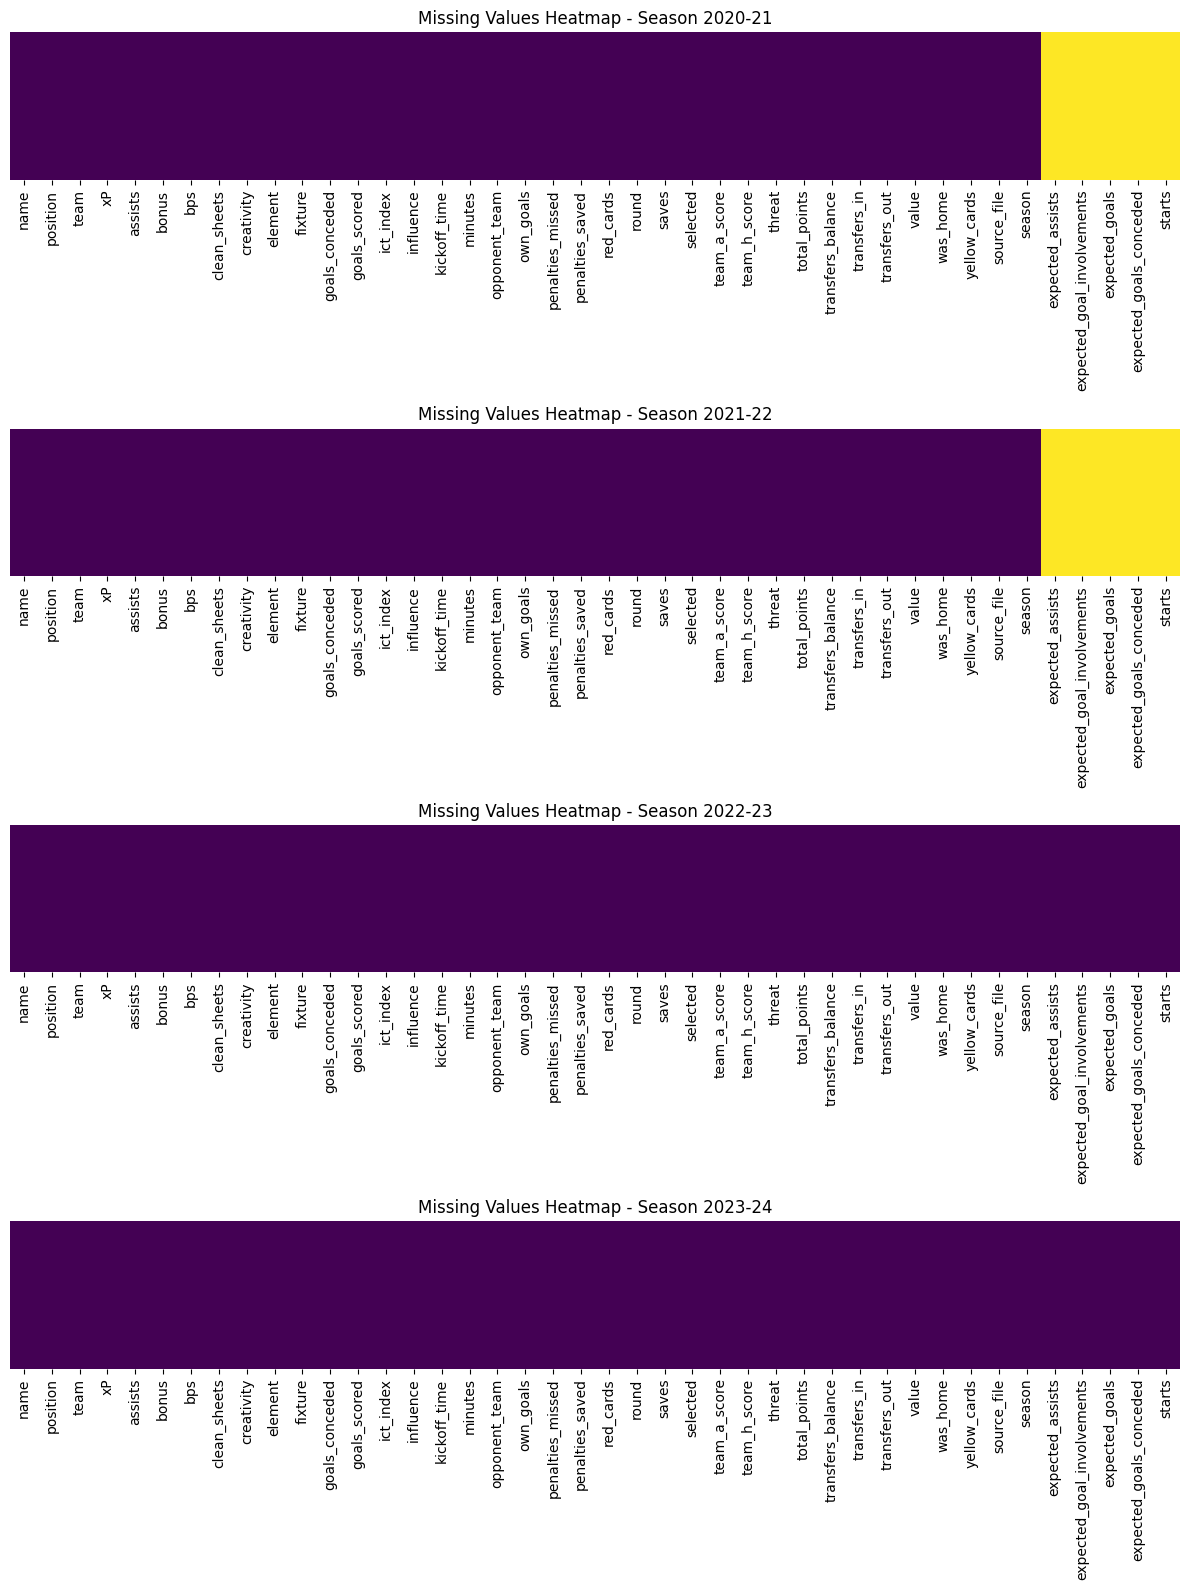

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mismap(df):
    seasons = df['season'].unique()
    
    # Create a subplot for each season
    num_seasons = len(seasons)
    fig, axes = plt.subplots(num_seasons, 1, figsize=(12, num_seasons * 4))
    
    if num_seasons == 1:
        axes = [axes]  

    for ax, season in zip(axes, seasons):
        season_df = df[df['season'] == season]
        sns.heatmap(season_df.isnull(), cbar=False, cmap='viridis', yticklabels=False, ax=ax)
        ax.set_title(f'Missing Values Heatmap - Season {season}')
    
    plt.tight_layout()
    plt.show()

plot_mismap(df_gameweek)